In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 1  # predict 1 day into the future

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5.960000e+03,5960.000000,5960.000000
mean,55.470969,56.162841,54.785379,55.494916,26.638197,4.237067e+07,0.002562,1.000671
std,34.166645,34.658273,33.658528,34.197385,18.961481,3.046236e+07,0.046281,0.025900
min,15.200000,15.620000,14.870000,15.150000,2.423500,7.111000e+05,0.000000,1.000000
25%,27.417500,27.710000,27.210000,27.457500,17.478850,2.185800e+07,0.000000,1.000000
50%,43.980000,44.500000,43.555000,43.990000,21.428700,3.814835e+07,0.000000,1.000000
75%,77.597500,79.025000,76.690000,77.690000,28.917300,5.712868e+07,0.000000,1.000000
max,178.940000,180.380000,175.750000,179.940000,112.330000,5.910522e+08,3.080000,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,111.685,112.777,111.515,112.33,112.33,23216875,0.0,1.0
1,2018-08-30,111.670,112.610,111.440,111.95,111.95,22798702,0.0,1.0
2,2018-08-29,110.450,112.030,110.270,112.02,112.02,20818044,0.0,1.0
3,2018-08-28,109.940,110.500,109.790,110.26,110.26,19151528,0.0,1.0
4,2018-08-27,109.270,109.640,108.510,109.60,109.60,19662331,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

df = df.sample(frac=1)  # Shuffle df

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,...,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5959.000000
mean,5.608983e-15,6.562892e-15,7.593113e-15,5.876078e-15,1.907817e-17,6.105016e-16,-1.430863e-17,-4.769543e-18,1.526254e-15,1.788579e-17,...,-2.442006e-15,2.480163e-16,-2.060443e-15,4.960325e-16,-3.205133e-15,7.631270e-17,-8.346701e-18,8.346701e-18,-4.273511e-15,0.083721
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.984872
min,-1.178556e+00,-1.169678e+00,-1.185792e+00,-1.278374e+00,-1.367611e+00,-7.778027e+00,-1.139119e+01,-4.325398e+00,-5.309731e+00,-3.670229e+01,...,-6.162033e+00,-6.026775e+00,-7.143713e+00,-6.911664e+00,-7.143713e+00,-3.177697e+00,-8.227952e+00,-8.986132e+00,-1.278374e+00,-15.606725
25%,-8.209924e-01,-8.207946e-01,-8.191125e-01,-4.831143e-01,-6.734850e-01,-4.603877e-01,-7.219137e-01,-4.813141e-01,-5.577705e-01,-4.760178e-02,...,-7.184231e-01,-1.949910e-01,-4.704856e-01,-4.758647e-01,-4.704856e-01,-2.275620e-01,-4.778304e-01,-4.708719e-01,-4.831143e-01,-0.867729
50%,-3.363860e-01,-3.365711e-01,-3.335735e-01,-2.744463e-01,-1.385863e-01,1.917199e-01,-3.820392e-02,-1.127155e-02,1.845463e-01,1.344013e-02,...,-2.169004e-02,-8.574325e-02,2.394569e-01,2.368061e-01,2.394569e-01,-3.157417e-02,7.647895e-03,1.757357e-02,-2.744463e-01,0.029180
75%,6.474629e-01,6.588573e-01,6.501331e-01,1.210258e-01,4.843691e-01,7.688946e-01,7.341295e-01,4.373455e-01,7.544168e-01,6.516727e-02,...,7.526565e-01,-1.908928e-02,7.384451e-01,7.396618e-01,7.384451e-01,1.693027e-01,4.634749e-01,4.719211e-01,1.210258e-01,1.002397
max,3.614524e+00,3.584831e+00,3.594716e+00,4.511027e+00,1.801077e+01,1.257206e+00,6.159403e+00,7.336595e+00,1.364429e+00,1.831073e+01,...,7.478065e+00,7.803166e+00,1.308217e+00,1.295186e+00,1.308217e+00,1.246479e+01,9.342215e+00,8.592048e+00,4.511027e+00,19.575074


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,1.645363,1.629180,1.683760,4.507329,-0.642570,1.241166,0.003426,0.010619,1.364429,0.013702,...,0.457942,7.803166,1.195655,1.209596,1.195655,0.018982,0.022336,0.032278,4.507329,0.339437
2,1.609650,1.612443,1.648994,4.511027,-0.707586,1.250611,0.404767,0.010619,1.364429,0.013702,...,7.478065,7.803166,1.195655,1.209596,1.195655,0.018982,0.053848,0.063811,4.511027,-0.062489
3,1.594721,1.568291,1.634731,4.418055,-0.762291,1.255493,-0.365787,0.010619,1.364429,0.198756,...,-5.162992,7.803166,1.195655,1.209596,1.195655,0.018982,-0.769478,-0.766593,4.418055,1.596227
4,1.575109,1.543474,1.596696,4.383191,-0.745523,1.254256,-0.375635,0.010619,1.364429,0.097671,...,-5.649100,7.803166,1.195655,1.209596,1.195655,0.018982,-0.279334,-0.270590,4.383191,0.602190
5,1.528273,1.512308,1.568467,4.319801,-0.825234,1.257206,-0.328820,0.010619,1.364429,0.120781,...,-5.890663,7.803166,1.195655,1.209596,1.195655,0.018982,-0.529458,-0.523094,4.319801,1.107011


In [6]:
num_rows = len(df)
# Use 90% for training and rest for validation
num_training = int(num_rows * 0.9)
num_validation = num_rows - num_training

training_examples = preprocess_features(df.head(num_training))
training_targets = preprocess_targets(df.head(num_training))

validation_examples = preprocess_features(df.tail(num_validation))
validation_targets = preprocess_targets(df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,...,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000
mean,-0.001763,-0.001697,-0.001756,0.000848,0.004279,-0.004130,0.003875,0.002524,0.004764,-0.003580,...,0.006101,0.004497,0.006278,-0.000192,0.000327,-0.000192,0.006339,0.014413,0.014427,0.000848
std,1.001818,1.001946,1.001711,1.001562,1.005963,1.002209,1.003912,1.003718,0.993253,0.987633,...,0.997122,1.001853,1.015790,1.003751,1.001448,1.003751,0.998271,1.001604,0.999640,1.001562
min,-1.178556,-1.169678,-1.185792,-1.278374,-1.367611,-7.778027,-11.391186,-4.276815,-5.128014,-36.702286,...,-3.151159,-6.099593,-6.026775,-7.143713,-6.911664,-7.143713,-3.177697,-7.883151,-8.575118,-1.278374
25%,-0.821431,-0.821805,-0.819410,-0.479290,-0.666063,-0.466507,-0.717926,-0.481450,-0.550769,-0.048818,...,-0.699872,-0.709163,-0.194853,-0.462549,-0.474390,-0.462549,-0.223124,-0.472272,-0.465253,-0.479290
50%,-0.344290,-0.345228,-0.341894,-0.274452,-0.138586,0.181780,0.003426,-0.010105,0.185058,0.013403,...,0.020706,-0.017216,-0.085446,0.241606,0.239490,0.241606,-0.028312,0.022336,0.032278,-0.274452
75%,0.631363,0.631154,0.634533,0.109732,0.480542,0.768114,0.738669,0.445107,0.752383,0.064495,...,0.700272,0.759125,-0.016494,0.735779,0.737488,0.735779,0.170672,0.473484,0.481852,0.109732
max,3.614524,3.584831,3.594716,4.511027,18.010770,1.257206,6.159403,7.336595,1.364429,18.310734,...,3.383742,7.478065,7.803166,1.308217,1.295186,1.308217,12.464792,9.342215,8.592048,4.511027


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,...,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,0.015866,0.015273,0.015803,-0.007633,-0.038500,0.037161,-0.034870,-0.022714,-0.042871,0.032215,...,-0.054900,-0.040464,-0.056488,0.001731,-0.002942,0.001731,-0.057040,-0.129690,-0.129816,-0.007633
std,0.984172,0.983016,0.985156,0.986628,0.944584,0.979944,0.964202,0.966420,1.058689,1.105464,...,1.024759,0.983074,0.843383,0.966410,0.987704,0.966410,1.014495,0.976743,0.994694,0.986628
min,-1.124987,-1.119755,-1.141517,-1.276747,-1.338272,-7.503453,-3.575357,-4.325398,-5.309731,-9.801813,...,-3.130318,-6.162033,-3.086705,-5.466894,-5.532051,-5.466894,-2.775846,-8.227952,-8.986132,-1.276747
25%,-0.817663,-0.818055,-0.816884,-0.508225,-0.690720,-0.431691,-0.766194,-0.478817,-0.647328,-0.037037,...,-0.776782,-0.791415,-0.194991,-0.494230,-0.503563,-0.494230,-0.258713,-0.530505,-0.524155,-0.508225
50%,-0.266571,-0.269190,-0.265972,-0.272851,-0.138616,0.233868,-0.089947,-0.026932,0.174905,0.013702,...,-0.057953,-0.100407,-0.088655,0.212637,0.209712,0.212637,-0.049865,-0.027029,-0.017159,-0.272851
75%,0.698543,0.734607,0.720260,0.188109,0.506120,0.782191,0.687187,0.404939,0.773110,0.079997,...,0.685624,0.690068,-0.031265,0.759820,0.756071,0.759820,0.140914,0.358250,0.367400,0.188109
max,3.023512,3.003359,3.048856,4.191966,8.066837,1.237220,5.557976,3.625789,1.364429,17.492331,...,2.735680,2.340120,7.803166,1.252114,1.277923,1.252114,10.366321,6.491621,6.124646,4.191966


Training targets summary:


count    5363.000000
mean        0.055070
std         1.979801
min       -15.606725
25%        -0.887243
50%         0.011581
75%         0.991148
max        18.604776
Name: future_percent_change, dtype: float64

Validation targets summary:


count    596.000000
mean       0.341527
std        2.013341
min      -11.376271
25%       -0.662119
50%        0.098048
75%        1.109138
max       19.575074
Name: future_percent_change, dtype: float64

In [7]:
display.display(validation_examples.head(5))
display.display(validation_targets.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
3717,-0.866218,-0.871583,-0.873490,-0.516838,1.421024,-2.248321,-1.648045,-2.884340,-0.399364,-0.308736,...,-2.412857,-0.241761,-0.194030,-0.327599,-0.313460,-0.327599,-0.190208,-0.076529,-0.066780,-0.516838
1789,-0.825530,-0.809829,-0.819707,-0.183810,2.170061,-0.361652,-2.087954,2.175162,0.891086,0.547820,...,0.938699,0.639840,0.288886,0.988685,0.991460,0.988685,0.333685,-0.282836,-0.274118,-0.183810
4593,0.239404,0.217775,0.216446,-0.320451,-0.488768,-0.525999,-0.526427,-1.147353,-0.349532,0.485326,...,-2.625904,0.177770,-0.176717,0.028905,0.109505,0.028905,-1.468480,-1.538894,-1.555176,-0.320451
5258,2.430744,2.408901,2.476847,-0.803449,-1.248684,0.679037,0.086981,0.075645,-1.516707,0.024249,...,1.119219,0.088638,-0.075198,-0.959786,-1.008740,-0.959786,0.559438,0.922984,0.925834,-0.803449
3851,-0.865926,-0.868698,-0.872599,-0.515786,0.598972,-0.309829,1.172107,-0.675388,0.014345,0.161513,...,0.368583,-0.406841,0.072909,0.109162,-0.076383,0.109162,-0.039501,1.671105,1.656216,-0.515786


3717    0.196558
1789    0.609224
4593    3.196887
5258   -1.755723
3851   -3.167909
Name: future_percent_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.453
  period 01 : 0.294
  period 02 : 0.231
  period 03 : 0.203
  period 04 : 0.173
  period 05 : 0.148
  period 06 : 0.158
  period 07 : 0.132
  period 08 : 0.120
  period 09 : 0.118
Model training finished.
Final RMSE (on training data):   0.118
Final RMSE (on validation data): 0.131


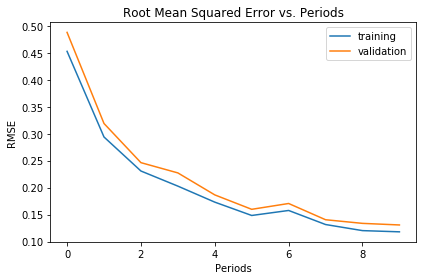

In [11]:
regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
    steps=2000,
    batch_size=30,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

(59, 30)
Darker corresponds to more negative, lighter corresponds to more positive.


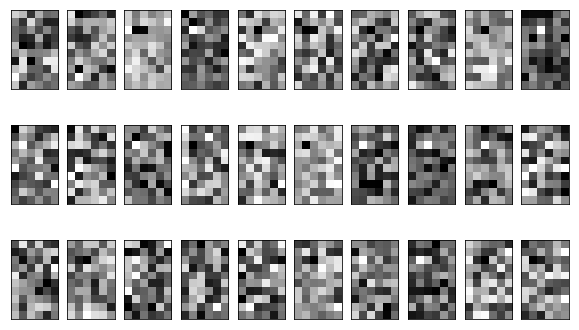

In [12]:
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    padded = np.pad(coef, (0, 1), "constant")
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

print("Darker corresponds to more negative, lighter corresponds to more positive.")
plt.show()

In [13]:
recent_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
recent_features = preprocess_features(recent_df).head(prediction_period)
recent_targets = preprocess_targets(recent_df).head(prediction_period)
predict_recent_input_fn = lambda: input_fn(recent_features, recent_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_recent_input_fn)
predictions = [item["predictions"][0] for item in predictions]
print("Current predictions (start of array is furthest into the future and end of array is 1 day into the future):")
display.display(predictions)

Current predictions (start of array is furthest into the future and end of array is 1 day into the future):


[0.05655796]